In [1]:
import torch
from tqdm import tqdm
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/jdolli/chelsaCLIP')
from src.models.components.loc_encoder import SirenNet
from src.utils.positional_encoding.spheregrid import SphereGridSpatialRelationEncoder
sys.path.append('/home/jdolli/chelsaCLIP/src/utils/test_cases')
from util_datasets import *

In [28]:
PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_098-v5.ckpt" #naive tiny old
#PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_093.ckpt" #naive large old
PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_025-v11.ckpt" #naive tiny
PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_015-v7.ckpt" #naive tiny
PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_072.ckpt" #naive base 0.02LOC
#PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_067-v2.ckpt" #naive base 1CH
#PATH = "/shares/wegner.ics.uzh/CHELSA/checkpoints/epoch_087-v1.ckpt" #naive base new
state_dict = torch.load(PATH, weights_only=False)
location_encoder = SirenNet(dim_in=384, dim_hidden=1024, dim_out=256, num_layers=4, dropout=False)
loc_enc_sd = {key[17:]:state_dict["state_dict"][key] for key in state_dict["state_dict"].keys() if key.startswith("location_encoder")}
location_encoder.load_state_dict(loc_enc_sd)
location_encoder.eval()
location_encoder = location_encoder.to("cuda")
pos_embedding = SphereGridSpatialRelationEncoder(coord_dim=2, frequency_num=64, max_radius=360, min_radius=0.0003,
        freq_init="geometric", device="cuda")
#feats = get_feats(loc_ip, date_ip, months, location_encoder, pos_embedding, use_months=True, pass

In [30]:
ds = WorldDataset()
#ds = ZurichDataset()
#ds = SwitzerlandDataset()
#ds = EuropeDataset()
#ds = LakeVictoriaDataset()
dl = torch.utils.data.DataLoader(
        dataset=ds,
        batch_size=8196,
        num_workers=0,
        shuffle=False,
    )

MONTH = 12

encodings = []
for lonlat in tqdm(dl):
    lonlat = lonlat.to("cuda")
    loc = pos_embedding(lonlat.double()).squeeze(dim=1).to("cuda")
    #month = torch.full([len(loc)], MONTH).to("cuda")
    #loc_month = torch.concat([loc, torch.sin(month/12*torch.pi*2).unsqueeze(dim=-1),torch.cos(month/12*torch.pi*2).unsqueeze(dim=-1)], dim=-1).to("cuda")
    loc_month = loc
    encodings.append(location_encoder(loc_month).float().detach().cpu())
    #encodings.append(loc.float().detach().cpu())
encodings = torch.cat(encodings, dim=0)

100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


In [31]:
def plot_single_dim(dim, tag):
    single_dim = encodings[:, dim]
    print(single_dim.min(), single_dim.max())
    try:
        imgs = np.zeros((ds.y_pixel, ds.x_pixel))
        imgs[ds.land_mask == 1] = single_dim
    except:
        imgs = single_dim.reshape(ds.x_pixel, ds.y_pixel)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.set_xlim([ds.W, ds.E])
    ax.set_ylim([ds.S, ds.N])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    im = ax.imshow(imgs, extent=(ds.W, ds.E, ds.S, ds.N))
    
    fig.colorbar(im, ax=ax)
    
    name = tag + "_" + str(MONTH) + "_" + str(dim)
    plt.show()
    fig.savefig("./visuals/" + name)

0
tensor(-42.3203) tensor(39.7568)


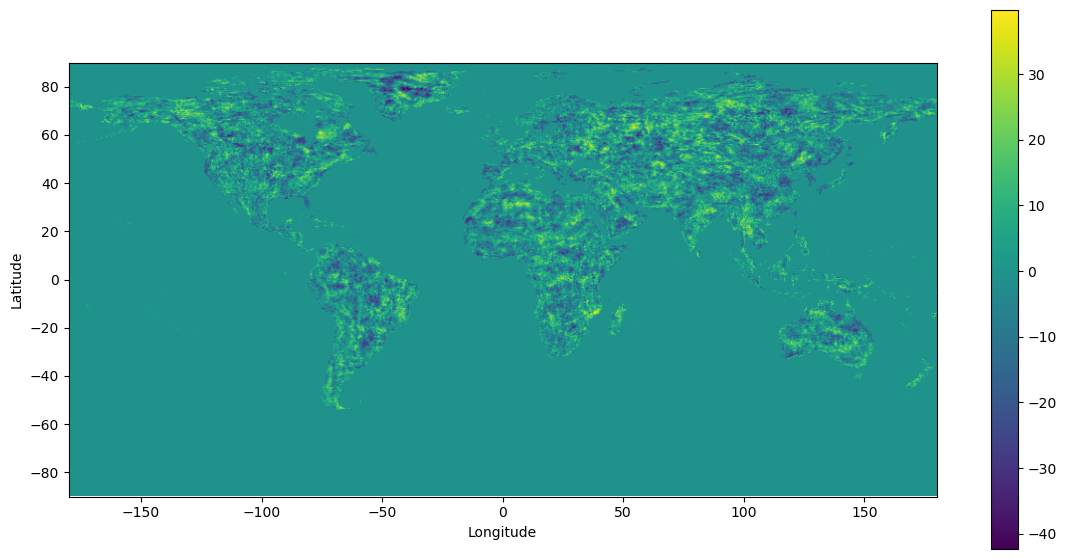

60
tensor(-11.5269) tensor(14.2597)


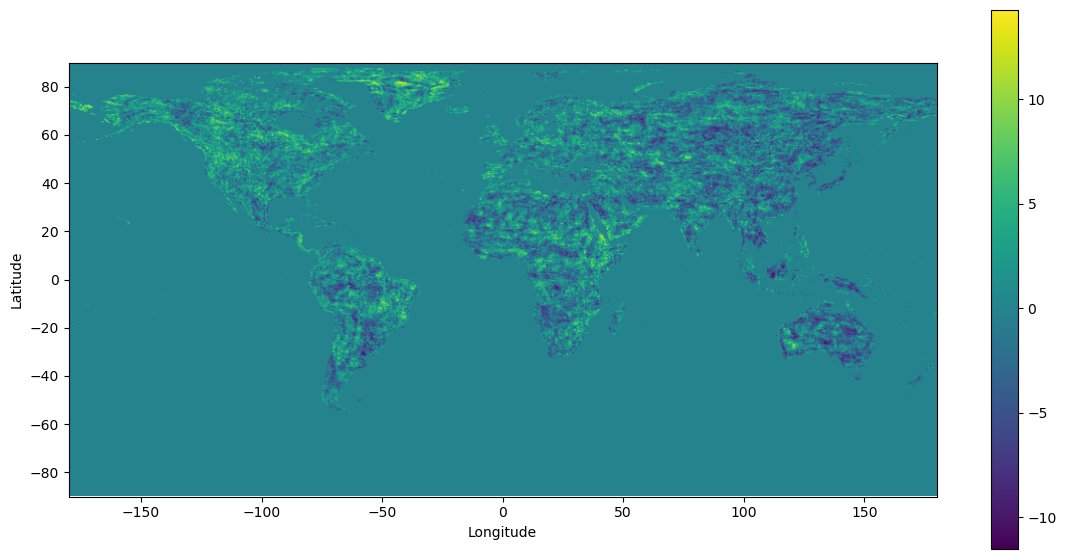

120
tensor(-11.4686) tensor(10.1365)


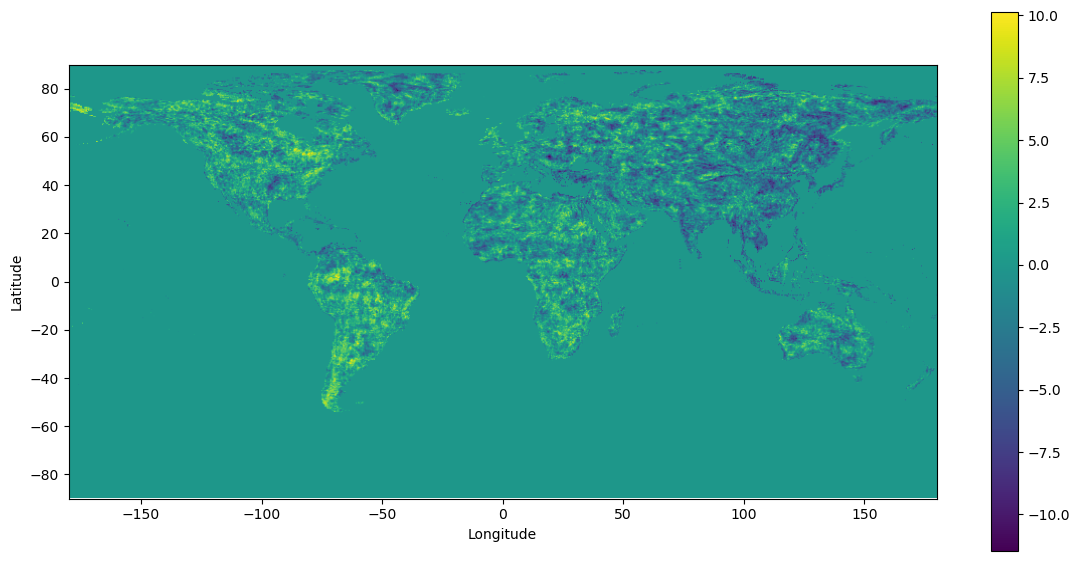

180
tensor(-14.0367) tensor(13.5849)


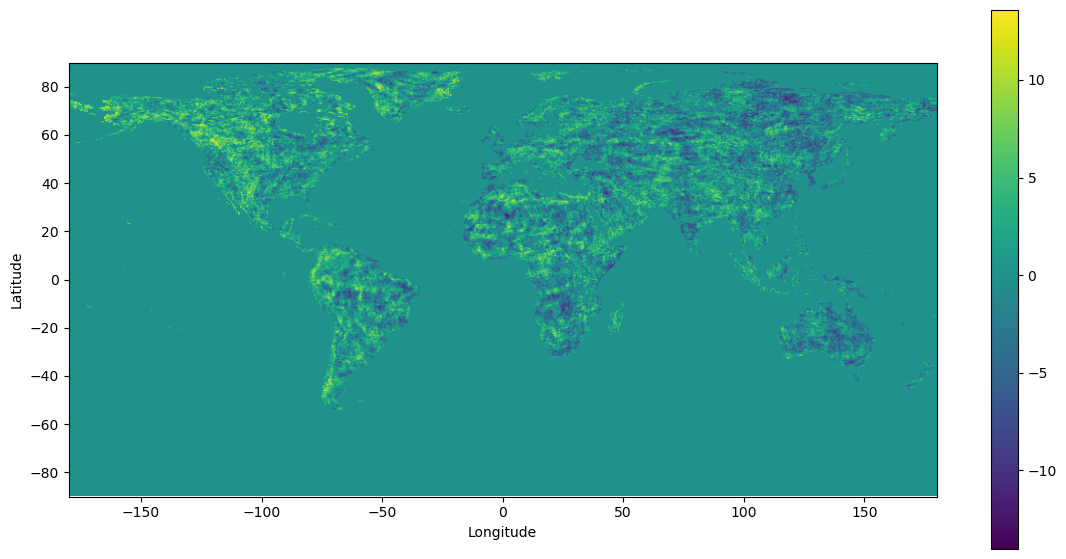

240
tensor(-17.2514) tensor(17.9998)


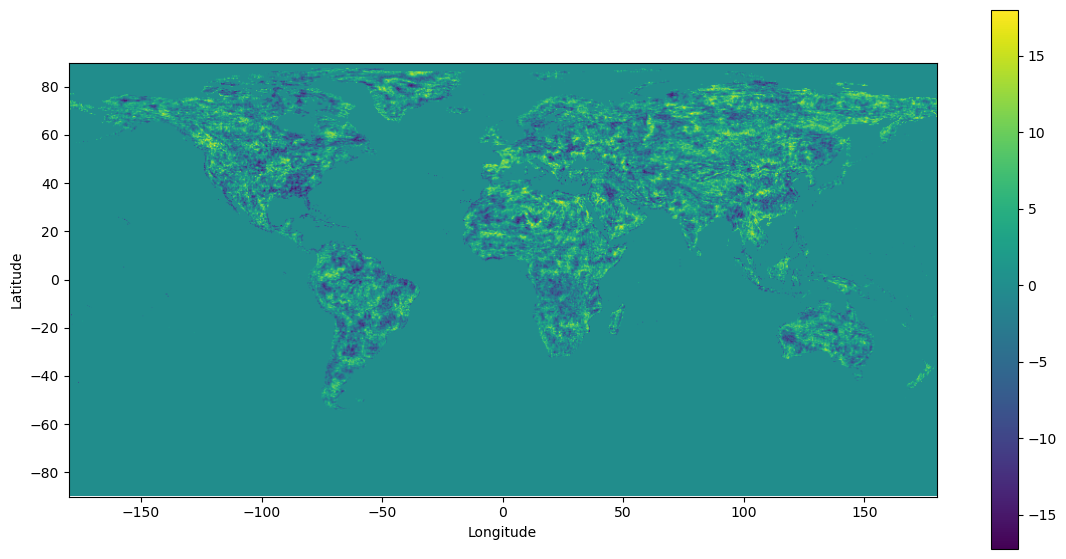

In [32]:
pos = 0
for i in [0+pos,60+pos,120+pos,180+pos,240+pos]:
#for i in [0+pos]:
    print(i)
    plot_single_dim(i, "new_base_02Loc")